# [AI 이노베이션 스퀘어] 12기 고급 시각반
- github: https://github.com/hysKim1/AI_Vision
    - [파이썬 공식문서]https://docs.python.org/ko/3/
    - [Numpy 공식문서]https://numpy.org/devdocs/
    - [ML]https://developers.google.com/machine-learning/crash-course/ml-intro?hl=ko
    - [DL]https://www.tensorflow.org/?hl=ko
      
---
* [Object Detection3](#Object-Detection3 )
    * [Faster R-CNN ](#Faster-R-CNN )
    
    
## Object Detection3

- 데이터셋 비교 : https://paperswithcode.com/sota/object-detection-on-coco

## Faster R-CNN
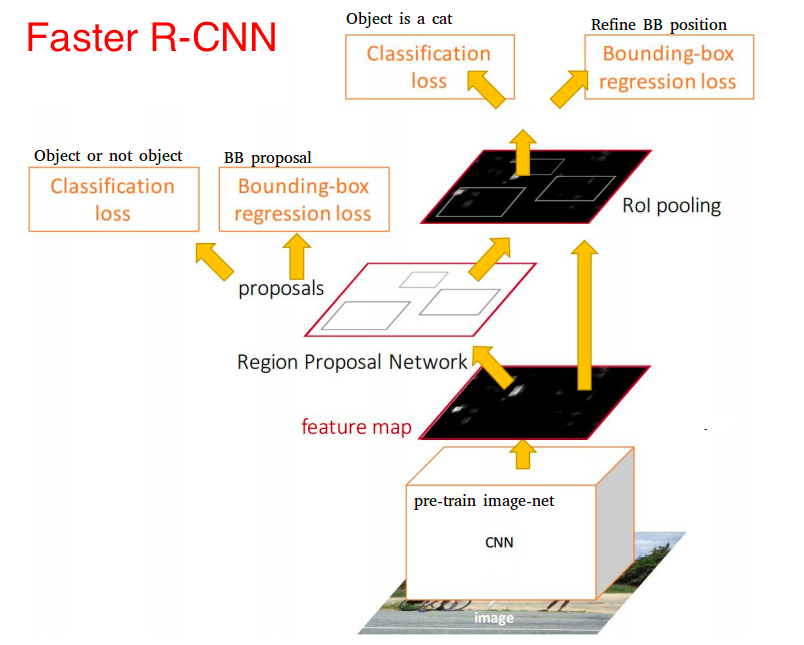
- SPP-net,Faster R-CNN,resnet,yolo by Kaiming He 
- 목표:  **'물체'가 있을만한 '위치'region proposals를 학습**을 통해서 찾는 방법
- R-CNN, Fast R-CNN에서 Selective Search가 병목현상을 일으키기 때문에 Region Proposal 단계를 Region Proposal Network를 이용해서 end-to-end model **속도 향상**
      - cls: object / not-object(background)
      - rgr: b-box (4 points)
  - convolution 특징: feature map에서  activation이 가장 큰 부분으로 물체 위치 '대략적으로 유추' 가능 
       > - JFnet convolution 특징 파악해서 fine-tuning 어느정도의 위치 파악 가능
       > - 참고: visualizing what convnets learn.ipynb
  - reduction: 각 지정된 비율,사이즈별로 9개의 anchor boxes(가장 많이 나올 물채 형태 크기) 값을 1개로 표현 
  탐색,계산해서 있는지 없는지 확인

- 1 stage 속도는 빠르나 정확도가 비교적 낮음 eg.YoLO, SSD 
- end-to-end model(1 pass): 사람이 지정한 유사도 기준으로 찾는 selective search 포기하고 **RPN Region Proposal Network 학습을 통해서 localization 해결**
   - selective serach가 전체이미지 슬라이딩 해서 병목현상 존재해서 진정한 1 pass 아님
- 원본,박스,  linear regression으로 어느 정보 보정해서 실제 값

1. 크기 맞추기
    - convolution 어느정도 localization 가능 (ZFnet)
    - convolution 단계에서 RP 제안 
    - feature maps - SPP/ RoI pooling layers 로 **크기 맞춤**
    - Resnet(2015)
2. RPN: 위치가 있을만한 미리 지정한 k개 anchor box 이용해서 RP 제안하는 NN 사용해서 selective search 대신해서 속도 향상함
> SPPNet(2014)-  어느정도 localization 수행

- slidign하면서 대략적인 물체 위치 몇가지 정해 놓고 통해서 있는지 체크
  - 특징 기반으로 이런 모양 이런 크기 미리 지정
  - 정확도는 어느정도 왔고 속도를 높이는데에 초점
 - convolution layer단계에서 있을만한 모양 가정하고 존재여부에 따라서 대략적인 모양 잡아냄.
- 실무적 적용 가능한 속도, 성능
- encoder or segmentation




-  IoU: positive sample: IoU >0.7, nagative sample: IoU < 0.3 
> 불균형 데이터 (imbalanced dataset) 카드사기비율이 전체 소유자에비해 적어서 학습이 잘 안됨

- 제안, 예측하고 나서 boxing regression 이용해서 제안했던 대략적 위치와 실제값을 한번 더 학습해서 정교하게 예측

- https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb
  - 모델마다 파인튜닝하는 지점 상이
  - target layer 특정한 애에 어떤 모양인지 평균을 잡아서 계산
  - @tf.function :tf전용 vectorization 최적화 기법
  - 시각화: 이미지에 대해서 convolution 각각이 어떻게 activation 된 부분과 공통적으로 겹치는 부분이 많으면 그럴듯한 영역이라고 가정
    - 암시적으로 위치에 상관 있음을 알 수 있음
    

### Anchor box

- selective sarch 대신에 region proposal 제안
>  image detection 크기 다름을 해결 방법
  1. Pyramid 크기 별로 이미지 다르게 만들기
  2. multiple filter scales/sizes
    - SPP-net
  3. **multiple references**
    - RPN
    
### Region Proposal Network(RPN)

    - multi-task loss: classification, regression 예측 :예.'물체'가 이 '사각형' 안에 있다.
      - convolution으로 학습통해서 featu분류객체, 위치를 동시에 반영가능 
    - linear regression : 정답과 실수간의 차이를 최소화
    - convolution 레이어로 들어오는 값이 feature잘 찾음, object 위치도 잘 찾음(공통적으로 사용해서 하나의 모델에 2개의 예측값)

- RPN 개선: 한번 더 학습 하지말고 위치 찾으면서 물체 맞추기 
- region proposal 여러개
> trends: 위치 찾으면서 어느 물체인지


800x800 (50x50 filter) -> 16x16개 내에 3개의 크기,스케일 (총 9개) 에서 영역 있는지 슬라이딩해서 확인(50x50x9=22,500 경우의 수)
영역이 많이 겹치는 부분IoU 계산  
- class IoU>0.7 or background

selective search 해봤더니 잘랐음
겹치는 부분이 있으면 학습 데이터 -> 예측  
**학습을 통해서** 칸볼루션된 결과가  rpn 에 들어가서 나온값과 정답 데이터 (label, b-box)과 비교해서 겹치는 부분을 IoU 차이를 최소화하는 convolution 학습 
 - 대략적 위치 파악 (class/background)
 - background 파악하지 않아서 속도를 더 빨리

> Fast r-cnn 차이점: 이미지에 selective search 사용해서 projection해서 있을만한 위치를 찾아서 roi pooling 하나의 FCL모아서 multi-task(클래스, 위치)
- 공통된 특성을 갖기 때문에 두개를 합친 loss구해도 학습이 잘됨

- localization: **위치가 있을만한 영역 제안하는 NN를 학습을 통해서** selective search 대신해서 속도 향상함
 >  ZF-Net 256 d, vGG 512
 - 제안하고 예측하고 나서 b-box regressor ㄱㅣㅂㅓㅂ 

  - 가정: 가장 있을 만한 크기,비율 따라 k 개의 다른 anchor boxes 지정

- 학습: 어떤 이미지 들어와서 feature map 들어왔을때 각각에대해서 전경/배경인지, 클래스인경우 4개의 점에대해 regression
학습 그림이 들어 왔을때 라벨링해서 학습 시키다 보면 이미지 들어 왔을때 k개 각각 class, 좌표값 
    - cls layer 클래스/배경
    - reg layer 좌표 값
      - 슬라이딩 하면서 계산 합치다 보면 특정영역 겹침 
          - positive > 0.7
          - negative < 0.3

 - grid 방식:k개 미리 지정된 anchor에서 각각 클래스 영역이 겹치는 정도에 따라서 예측
 각 영역을 탐지해서 학습시킬때 convolution 넣을때 어떤 모양이 합쳐져서 그럴듯한 클래스 영역일거라 예측하면서 특정 모양이 나옴 (겹치는 영역을 잘라서 물체 후보군과 배경 분리
 - ROI pooling  모양 맞춰주는 테크닉 (Fast R-CNN by Ross Girshick)
 - 각 9개 ancor box에 대해서 배경/class 
 배경
 ** selective srach 슬라이딩해서 하나씩 들어가면  학습시에 클래스 여부, 좌표값 위치 겹치는 영역 기준으로 class, 배경 정함

 > selective search 4개 유사도 기반으로 제안
vgg (50 50 512) 800x800 -> 16x16  에서 225000(50x50x9)개의 공간에서 9개의 anchors 로 슬라이딩하면서 확인함 , class랑도 겹쳐야함 
입력 받았을때 어디에 가장 그럴싸한 영역인지 예측

---
계속 9개 가
IoU구해서 0.7 크면 class 학습데이터로 만듦  
  > - State of Art 서로 참고 많이하는데 YOLO(2015)

- vectorization 동시에 여러개 처리, GPU
- 실용화
- edge boxes 빠르게 물체가 있을 만한 영역 잡아냄

전체 모델을 연구하는게 하니라 특정 모델에 하나하나  적용해서 수정 

singe stage method 
- 정해진 위치, 크기의 객체의 고정된 갯수만 찾음
- 일정 크기 이하는 무시함
- Faster R-CNN 1sec 2 pics, YOLO 1sec 35 pics
 
어느정도의 유연성, 정해진 크기, 비율로 탐색해서 속도가 빠르지만 정확도는 떨어

> 인간 뛰어넘은 이후 경량화 됨
---
Kaiming He ICCV15 tutorial session
 - Convolutional Feature Maps.pdf

 - Convolution
  - Feature: what,where(implicit 2차원 정보)
  - feature map : where
 - **transitional invariant** 위치 이동 무관
 - rotation, scale : 취약해서 data augmentation 보완

  - HOG(Histogram of Gradient) : 색상의 변화하는 정도에 따라서 구분, SIFT과 같은 전통적인 기법을 넘어서 숨어있는 의미를 학습을 통해서 알 수 있음
    - feature map 가장 활성화 된 부분(가장 큼)
      - 위치와 어떤 모양인지 시각화 SPP-net < ZFNEt
      - 예. 몸통,팔사이 $\lambda $모양
      - 깊은 레이어에서는 고유의 특징을 밝힐수 있음
        - activation 위치 따라서 위치도 어느정도 알수 있음 예. 자동차 바퀴는 밑에 위치

- feature map에 selective search
- 이미지에 있는 selective search를 feature map에 projection
  - BoW, SPP layers
    - feature pyramids
      - 이미지 크기가 input 크기 별로하면 크기 변경해서 fature map 
      - overFeat(2013): HOG,SIFT 사용
      - scale 비교해봤더니 1 개로도 충분

 Region Proposal from feature maps
 - selective search, edge box (느림)
  - convolution 공간 정보를 갖고 있으니 feature map에서  찾아보자!

Feature map sliding : 
  - cls: object or not-object
  - rfr: b-box locations
  이미지와 관련된 부분으로 데이터 구축 n 개 anchors( pre-defiend ref boxes) 
    - positive : IoU > 0.7
    - negative: IoU < 0.3 (제외하려고)
    - transitional invariant anchors 
    - 슬라이딩 하고 최종적으로 클래스인지 아닌지
       - Anchor Pyramid : 3 scale, 3 ratios
        -  각 anchor에 대해서 학습데이터 구축 
        - 9 개 anchors 그럴듯한 위치 찾아서 roi pooling 해서 기반으로 예측, regression 
        - k개의 anchors, ground truth 이용해서 가장 많이 중첩되는 부분일것이라고 예측 (IoU)
        
       - 각 anchor마다 예측 함수 존재(하나의 feature에서 multi-scale prediction)

      > - FCN(fully convolutional network : convolution 만 사용하고 dense 사용 안  함 -> segmentation에 활용( piexel 단위로 위치 추정)
        - FCN 기법중 하나 예측 1x1 결과로 각 convolution 따라서 영역 잡음

  - 이전 feature extraction 이였는데 어디에 있는지도 찾음

  - keras Faster R-CNNgit : https://github.com/kentaroy47/frcnn-from-scratch-with-keras
  - kaggle notebook https://www.kaggle.com/kishor1210/train-faster-rcnn-using-keras


---
object detection data set
- xml, csv,json 포맷으로 label , 좌표값 4개 

1. config 객체
  - 크기, 영역등의 옵션 바꾸어서 실험할때 편하게 할수 있도록 configuration 구성해서
다양한 실험 가능 
  - 객체방식으로 구성해서 인스턴스해서 옵션 바꿈
  - anchor box scale, ratios , image size
  - num_rois 
  - balanced_classes : 균형 데이터 (positive : negative )
  - IoU 구분 기준
  > 기본반  imbalanced datasets x:y=9:1 이면 x가 9배 많아서 영향력 쌤 ->over/under sampling 비율 맞춤
  - 성능 측정 기준: precision ,recall
 A:[[9999 0 ][ 0 1 ]] B:[[9999 1 ][ 0 0 ]]
 precision 99.99% 는 동일, recall 
 eg. 카드 사기( 사기 당할 확률이 전체 소지자에 비해서 매우 적으나 사기탐지 모델에서는 recall이 더 적합한 기준) 


In [ ]:
class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'vgg'

		# Setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# Anchor box scales
    # Note that if im_size is smaller, anchor_box_scales should be scaled
    # Original anchor_box_scales in the paper is [128, 256, 512]
		self.anchor_box_scales = [64, 128, 256] 

		# Anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]

		# Size to resize the smallest side of the image
		# Original setting in paper is 600. Set to 300 in here to save training time
		self.im_size = 300

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 4

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		self.model_path = None

2. get_data
  - multi-class 구성 복잡해서 파일 불러오기 중요 :xml, json, pandas DataFrame
  - PIL,numpy(다양한 프레임워크에서 이용), tensor(tf)
  - 해당 예시에서는 dictionary 방식
 


In [ ]:
def get_data(input_path):
  """Parse the data from annotation file
  
  Args:
    input_path: annotation file path
      
  Returns:
		all_data: list(filepath, width, height, list(bboxes))
		classes_count: dict{key:class_name, value:count_num} 
			e.g. {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745}
		class_mapping: dict{key:class_name, value: idx}
			e.g. {'Car': 0, 'Mobile phone': 1, 'Person': 2}
	"""
  found_bg = False
  all_imgs = {}

  classes_count = {}

  class_mapping = {}

  visualise = True

  i = 1
	
  with open(input_path,'r') as f:
    print('Parsing annotation files')
    
    for line in f:
      
      # Print process
      sys.stdout.write('\r'+'idx=' + str(i))
      i += 1
      line_split = line.strip().split(',')
			# Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
			# Note:
			#	One path_filename might has several classes (class_name)
			#	x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
			#	(x1, y1) top left coordinates; (x2, y2) bottom right coordinates
			#   x1,y1-------------------
			#	|						|
			#	|						|
			#	|						|
			#	|						|
			#	---------------------x2,y2
      (filename,x1,y1,x2,y2,class_name) = line_split
      
      if class_name not in classes_count:
        classes_count[class_name] = 1
      else:
        classes_count[class_name] += 1

      if class_name not in class_mapping:
        if class_name == 'bg' and found_bg == False:
          print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
          found_bg = True
        class_mapping[class_name] = len(class_mapping)

      if filename not in all_imgs:
        all_imgs[filename] = {}
				
        img = cv2.imread(filename)
        (rows,cols) = img.shape[:2]
        all_imgs[filename]['filepath'] = filename
        all_imgs[filename]['width'] = cols
        all_imgs[filename]['height'] = rows
        all_imgs[filename]['bboxes'] = []
				# if np.random.randint(0,6) > 0:
				# 	all_imgs[filename]['imageset'] = 'trainval'
				# else:
				# 	all_imgs[filename]['imageset'] = 'test'

      all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


    all_data = []
    for key in all_imgs:
      all_data.append(all_imgs[key])
		
		# make sure the bg class is last in the list
    if found_bg:
      if class_mapping['bg'] != len(class_mapping) - 1:
        key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
        val_to_switch = class_mapping['bg']
        class_mapping['bg'] = len(class_mapping) - 1
        class_mapping[key_to_switch] = val_to_switch
		
    return all_data, classes_count, class_mapping

3. RoiPoolingConv

- 역할: 전체 이미지가 영역으로 들어오면 pool size만큼 나눠주어서 크기와 상관없이 크기 맞추는 테크닉
- pool_size : 7x7 1개
    > SPP layer:1x1,2x2,4x4...(multi-scale) 피라미드 
- `tf.keras.layers.Layer` **상속**받아서 커스터마이징 
    - __init__ 초기화, call 핵심 구성
    - 입출력 모양 맞추기: build(한 번만 실행), compute_output_shape
    - get_config 추가적 구성
- `update` (mutable technique)
- call -> build -> __call__ -> callable , 객체() -인자 받을 수 있음
 - pooling layer instance -> call 통해서 feature map 받음
 
 () () functional paradigm 


In [ ]:
class RoiPoolingConv(Layer):
    #roi pooling: 등분해서 이미지 크기에 상관없이 동일한 갯수로 표현
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.common.image_dim_ordering()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)
        #데이터 x [img, rois]
        # x[0] : image with shape (rows, cols, channels)
        img = x[0]

        # x[1] : roi with shape (num_rois,4) with ordering (x,y,w,h)위치정보
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois)  #여러개 RoI  각각의 좌표값 4개(int32 로 typecasting)
            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]
# backend: 다른 프레임워크 thiano, tf, cntk 간에 자주 쓰는 메소드들 호환할 수 있도록 범용적 멕소드 모아놓음 (Numpy)
            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            #이미지의 roi 를 pool size(7x7) 로 resize -> 이미지 RoI projection 좌표값 [ x,y ,h,w] ->각 영역별 pooling
            #resize 하면 interpolation보간법 따라서 값 달라짐            
          #목적: 이미지 width, height 구해서 등분한후 pooling해서 넣음 
          # 학습: (batch size , h ,w ,c)  각각의 구성을 pooling size 7x7로 resize rs 7x7
          #구현 테크닉 : 구조체 만들고 pooling 값 대체하는게 아닌 바로 resize     
            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose(전치)
        # roi pooling layer 7x7 을 flatten해서 1열로 나열하기 위해서 결과값 표현하는 방식
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()

        base_config.update(config) #mutable
        return base_config

In [1]:
import tensorflow as tf
#transpose aixs technique :공간 순서대로 배열 (thiano 명령어 사용)
tf.keras.backend.permute_dimensions(tf.constant([[1,2],[3,4]]),(1,0))#function , pattern (1,0)전치

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 3],
       [2, 4]], dtype=int32)>

In [2]:
tf.keras.backend.permute_dimensions(tf.constant([[1,2],[3,4]]),(0,1)) 

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4]], dtype=int32)>

In [6]:
x,y =tf.keras.datasets.mnist.load_data()
img=x[0][0].reshape(28,28,1) #이미지 1개

In [7]:
t=tf.image.resize(img, (1,1), method='bilinear')#3,4차원 이미지만 가능
t #resize를 pooling처럼 할 수도 있음 

<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[196.75]]], dtype=float32)>

4. ConvLayers
- transfer learning 으로 가능
> - ZFnet: convolution visualization
> - VGG16: 3x3 filter 2/3개 겹치면 5x5 / 7x7와 동일한 효과를 주며 성능,연산 좋음 
- 간단한 구조 + 작은 커널 사용해도 큰 커널만큼 큰 특징 잘 찾음
fastRCNN 7x7 비선형 때문에 size에 robust함 
- convolution 이미지 크기 상관 없이 사용할 수 있으나 예측에서는 크기 맞춰야

In [ ]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length//16

    return get_output_length(width), get_output_length(height)    

def nn_base(input_tensor=None, trainable=False): 
    #VGG16 기본적 구성/전이학습도 가능
    
    input_shape = (None, None, 3)
    if not K.is_keras_tensor(input_tensor):
      img_input = Input(tensor=input_tensor, shape=input_shape)
    else:
      img_input = input_tensor

    bn_axis = 3

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x

5. RPN layer
- region proposal network 이론상 네트워크지만 convolution으로 이루어진 1개의 layer 
- TensorFlow, Pytorch 등으로 만들때 모델을 레이어로도 만들수 있음
tensorflow layer 내부에서도 레이어 여러개 쌓을 수 있음(예. `hub.KerasLayer(cls_url)`
기본적인 네트워크 모델에 convolution layer의 결과인 feature map 이 입력으로들어가서 2개의 output

- input : convlayer feature map
- **output: 1x1 classifier, b-box regressor** 차원 축소  

 base_layers -> RPN -> 2 oupts (functional paradigm)
  - 있을만한 영역 roi pooling 
>     selective search 대체한거 외에는 그대로




In [ ]:
def rpn_layer(base_layers, num_anchors): #핵심 몇개의 anchor로 파악하는지
    """Create a rpn layer
        Step1: Pass through the feature map from base layer to a '3x3 512개 channels convolutional layer
                Keep the padding 'same' to preserve the feature map's size
        Step2: Pass the step1 to two (1,1) convolutional layer to replace the fully connected layer
                classification layer: num_anchors (9 in here) channels for 0, 1 sigmoid activation output
                regression layer: num_anchors*4 (36 in here) channels for computing the regression of bboxes with linear activation
    Args:
        base_layers: vgg
        num_anchors: 9

    Returns:
        [x_class, x_regr, base_layers]
        x_class: classification for whether it's an object
        x_regr: bboxes regression
        base_layers: vgg in here
    """
    # vgg16 (512, (3,3)) - > convolution layer의 feature map의 activation -> 대략적 위치(implicit암시적)  +  class 
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    
    #functional paradigm multi-inputs,-outputs : 각 9개의 convolution 결과 -> 1x1 convolution (차원축소)classsificaton, regression
    #2k sigmoid 사용한 binary classification이므로 2k아니여도  0,1 결과값을 냄
    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    #4k
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

6. Classification layer

 > selective sarch: 4개 기준 grouping 제안
 > 정답데이터를 통해서 학습을 할 수 있도록 해야함
 > ZF 256 dim, VGG 512 dim ;
- 값 여러개 들어오면 tf layer에서는 합쳐서 하나의 결과값으로
n 개 rois 입력 되면 각각 classifier -> roi pooling layer (input) 
- roi pooling 레이어에의 동시에 여러 결과값 나오며 각 결과값들을 별도의 모델에 넣기위해서 `TimeDistibuted`로 감싸서 각각의 계산 결과를 냄

> Fast R-CNN : multi-task loss 사용
  - 앞단에 특징 공유해서 하나의 모델에 두가지 동시에가능

In [ ]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):
    """Create a classifier layer
    Args:
        base_layers: vgg
        input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
        num_rois: number of rois to be processed in one time (4 in here)

    Returns:
        list(out_class, out_regr)
        out_class: classifier layer output
        out_regr: regression layer output
    """

    # fast r-cnn: feature map, RPM 결과를 받아서 원본, 위치 projection 통해서 나온걸 덮어 씌움

    input_shape = (num_rois,7,7,512)  #7x7

    pooling_regions = 7
    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    # 7x7 개의 pooling_regions, num_rois=4  만큼 받는 pooling layer에 inputs 두개
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    #TimeDistributed: 각 입력 값을 각각 계산해서 예측
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    #multi-task loss :Linear + softmax, linear regression
    # out_class: softmax acivation function for classify the class name of the object ,not object
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # out_regr: linear activation function for bboxes coordinates regression 4개의 좌표값 예측 
        # linear 학습 테크닉: 입력이 동일하고 동시에 sync를 맞추기 위한 구현 테크닉

    #git code in Python(Caffe)& Matlab 제공 -> tensorflow용 포팅함그림만 다르게 그린것 
       # background class RPN : 클래스아닌 배경은 b-box할 필요 없음 -> 4*(4-1) :background class 제외 , no regression target for bg class 
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)
    
    return [out_class, out_regr] 

7. IoU
- Intersection of Union 겹치는 영역 계산
 - anchor별 크기 구함 
 - 전체 영역에서 가장 큰애 구한 후 겹치는 영역 IoU 계산  : >0.7 or < 0.3
 
- RPN : 3x3 convolution으로 전체 컨볼루션해서 미리 정해진 anchor로  있을만한 영역에서 겹치는 부분 
예. 공이 있는 그림을 convolution -> feature map (activation) -> RPN  convolution -> anchor 기준으로 activation 연관해서 가장 유사한 부분 IoU 
학습 통해서 유사한 데이터 왔을때 A이면서 좌표값 가장 잘 찾
loss
convolution 통해서 예측,위치 잘 정하는 애로 3x3 모양바

In [ ]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

In [ ]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
	"""(Important part!) Calculate the rpn for all anchors 
		# feature map : shape 38x50=1900 -> 1900x9=17100 potential anchors 탐색해서 그럴듯한 영역 찾음
	
	Args:
		C: config
		img_data: augmented image data
		width: original image width (e.g. 600)
		height: original image height (e.g. 800)
		resized_width: resized image width according to C.im_size (e.g. 300)
		resized_height: resized image height according to C.im_size (e.g. 400)
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

	Returns:
		y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
			y_is_box_valid: 0 or 1 (0 means the box is invalid, 1 means the box is valid)
    """


    # anchor를 통해서 정확한 점 찾아가는 단계 

#  the GT(ground truth) box coordinates(실제 좌표값)받아서, resize to account for image resizing
	
    gta = np.zeros((num_bboxes, 4))  # 좌표값 0 초기화
	for bbox_num, bbox in enumerate(img_data['bboxes']):
        
		# get the GT box coordinates, and resize to account for image resizing
    # feature map에 있던 resized 크기  각 anchor 비율/사이즈 기반으로 실제 영역 유추
    # fast-rcnn: 이미지에서 selective search해서 convolution 한 부분 resize해서 feature map 매핑, 
    
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
  #앵커에 컨볼루션-> 축소 앵커에대한 실제 크기
  # 9개 anchors (diff scale & sizes) 예. 비율 1,2,3 원본의 특정점 비슷하게 구함
 #사이즈 , ratio 별 anchors 좌표값 찾아감
	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			# 현재 anchor 기반으로 x,y값 찾기
			for ix in range(output_width):					
				# x-coordinates of the current anchor box
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2  
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2	
				
				# 'ignore' boxes that go across image boundaries				
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for jy in range(output_height):

					# y-coordinates of the current anchor box
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2

          #초기값 neagative, 
          #후보 IoU >0.7 기준인데  속하지않으면 가장 큰 값 기준으로 함 (imbalanced) 
          #9개 anchor 나온 각각의 영역들을 값 구해서 boundary에 맞춘 값들 pos, neg, neutral 로 할당(비율 맞춤)  (실제값,예상값 차이 비교 )
          # 0.7 아니여도 그다음 큰 값으로 pos 로 바꿔서 비율 맞춰서 적어도 모든 b-box가 최소 1개의 RPN 영역이 있게 만듦
          # iou 구해서 제일 좋은 애들 찾음
          # 모양 맞춤, np.where 조건식 np.logival_and 두 조건 만족해야함(교집합)
          # pos_locs 새로운 포지션 ,클래스 예측 #다 이거 기반으로 단순화함
          #train  GT 컨볼루션해감  9개 앵커를 슬라이딩해서 iou 계산해서 pos, neg, neutral 나눔
          # negative가 많아서 치중되는것을 방지하기위해 비율 맞추도록함 
          # pos 오버랩된 부분이 많은 곳은 영역으로 예측
          # 컨볼루션된것을 보지만 거꾸로 맵핑도 가능 (그런 효과
          # selective search 아니고  차이를 최소화 하는 convolution찾음 학습을 통해서 찾음
          #for도 많음  영역 잡는게 중요
          # 이기법을 바탕으로 더 좋은 바
          #학습단계임 : 실제데이터  9 anchor값에 대해서 convolution 계속 겹치는 부분 찾아감 
          # 가장 많이 겹치는 사각형 mps로 겹치는 부분 찾음 
          # proposals 겹치는 부분 convolution하고난 결과에 대해서 겹치는 부분 계산 
          #필터에 따라서 활성화 정도가 달라서 겹치는 부분 결과 달라짐으로 학습으로 가장 많이 겹치도록 함.(여러개 제안)
          #FCN (fully convolution network) 
          # RPN layer!!!


In [ ]:
def get_new_img_size(width, height, img_min_side=300):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

	if augment:
		rows, cols = img.shape[:2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2        
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img